In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Create some artificial test data of a simple image and lines to test


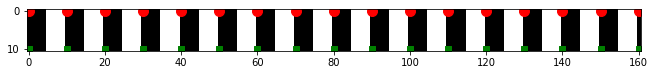

In [2]:
# Simple striped rectangle
width = 5
height = 11
n_reps = 16
img = np.tile(np.concatenate([np.zeros((height,width,3)),np.ones((height,width,3))],axis=1),(1,n_reps,1))
img = np.concatenate([img, np.zeros((height,1,3))], axis=1)
# Control curves.
img_height, img_width = img.shape[:2]
c1 = np.asarray([[0,c] for c in range(0,img_width,width*2)])
c2 = np.asarray([[height-1,c] for c in range(0,img_width,width*2)])

fig, ax = plt.subplots(figsize=(img_height,img_width))
ax.scatter(c1[:,1],c1[:,0],c='r',marker='o',s=100, label='c1')
ax.scatter(c2[:,1],c2[:,0],c='g',marker='s',label='c2')
ax.imshow(img, interpolation='nearest')
#ax.legend()


In [3]:
import cv2

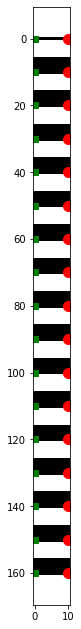

In [4]:
angle = np.pi/2
rot90 = np.asanyarray([[np.cos(angle), -np.sin(angle)],[np.sin(angle),np.cos(angle)]])
#c190 = rot90.as_rotvec()#*c1
c190 = np.dot(c1,rot90)+[0,height-1]
c290 = np.dot(c2,rot90)+[0,height-1]

fig, ax = plt.subplots(figsize=(img_width,img_height))
cv2rot90 = cv2.getRotationMatrix2D(((img.shape[1]-1)/2,(img.shape[1]-1)/2),90,1)
img90 = cv2.warpAffine(img,cv2rot90, (img.shape[0],img.shape[1]),1,cv2.INTER_NEAREST)
ax.imshow(img90, interpolation='nearest')
ax.scatter(c190[:,1],c190[:,0],c='r',marker='o',s=100, label='c1')
ax.scatter(c290[:,1],c290[:,0],c='g',marker='s',label='c2')


# Now, transform rotated to cannonical rotation and check differences.

In [5]:
from rl_image_warping import image_warping

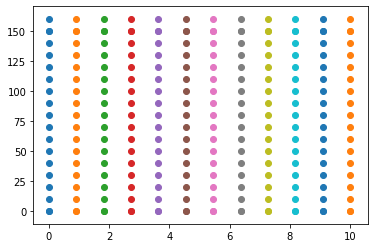

In [13]:
interpolator = image_warping.InternalCurveInterpolator(curve_0=c290, curve_1=c190, num_lines=10,
                                             inward_direction=image_warping.Side.LEFT_SIDE)

fig,ax = plt.subplots()
for l in interpolator._ratio_lines:
    ax.scatter(l[:,1],l[:,0])

In [8]:
img_new, c2_new,c1_new, proj_err = image_warping.reproject_snakelike(c290, c190, img90,n_nearest=1, projection_radius_out=True, verbose=True)

Calculating ratio line coordinates


[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00

Calculating ratio line coordinates



Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00

Calculating ratio line coordinates



Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00


Calculating ratio line coordinates


[100 %] Time elapsed: 00:00:14 | ETA: 00:00:00
Total time elapsed: 00:00:14


Determining inside coordinates in projected space.
Finding nearest neighbors.
Building image.


In [9]:
# recovered original shape?
print(f'Old shape: {img.shape} vs. New shape: {img_new.shape}')

Old shape: (11, 161, 3) vs. New shape: (11, 161, 3)


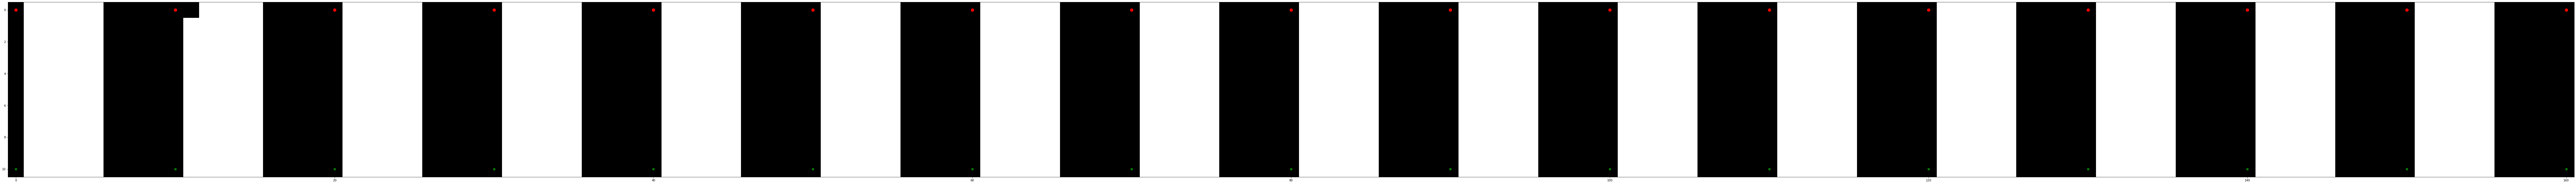

In [10]:
fig, ax = plt.subplots(figsize=(img_width,img_height))
ax.scatter(c1[:,1],c1[:,0],c='r',marker='o',s=100, label='c1')
ax.scatter(c2[:,1],c2[:,0],c='g',marker='s',label='c2')

ax.scatter(c1_new[:,1],c1_new[:,0],c='r',marker='*',s=100, label='c1 reproject')
ax.scatter(c2_new[:,1],c2_new[:,0],c='g',marker='x',label='c2 reproject')
ax.imshow(img_new, interpolation='nearest')

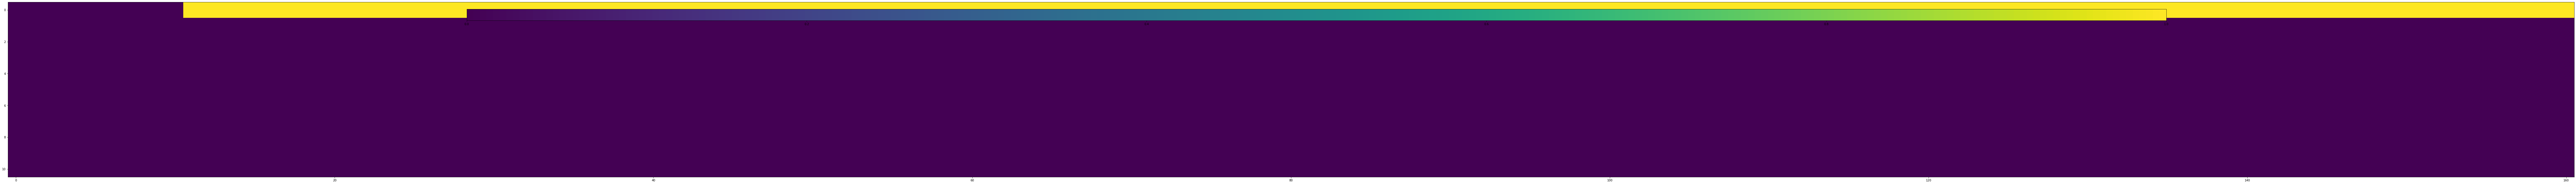

In [11]:
fig, ax = plt.subplots(figsize=(img_width,img_height))
im= ax.imshow(proj_err)
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])

fig.colorbar(im, cax=cax, orientation='horizontal')


In [14]:
# stats on proj err
np.min(proj_err),np.median(proj_err),np.max(proj_err)

(0.0, 5.329070518200751e-15, 1.0)

# Sinusoidal stretch

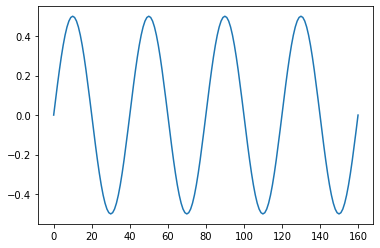

In [15]:
# make a sin with period of width * 8 and amplitude 2
# which will be centered at the mid

amplitude = 0.5
stretch = np.sin(np.arange(img_width)/(8*width/(2*np.pi))) * amplitude
plt.plot(stretch)

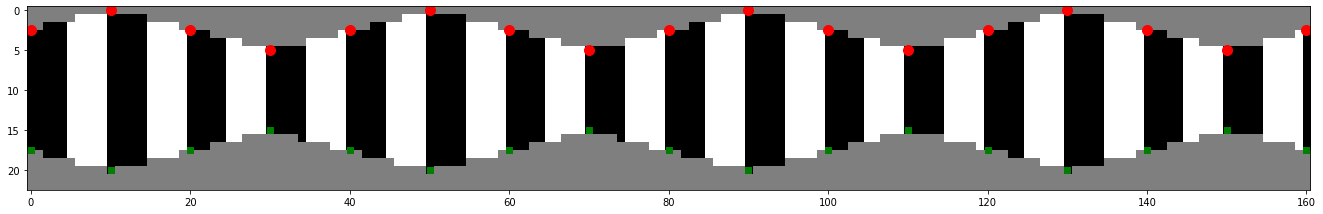

In [16]:
mid_y = (img_height-1)/2
join_b = np.asarray([[mid_y,0]])
join_e = np.asarray([[mid_y,img_width-1]])

c1_stretch = np.copy(c1).astype(float)#np.concatenate([join_b, c1, join_e],axis=0)
c1_stretch[:, 0] -= mid_y
c1_stretch[:, 0] = c1_stretch[:, 0]* np.sin(c1_stretch[:,1]/(8*width/(2*np.pi))) * amplitude
c1_stretch[:, 0] += mid_y*amplitude

c2_stretch = np.copy(c2).astype(float)#np.concatenate([join_b, c2, join_e])
c2_stretch[:, 0] -= mid_y
c2_stretch[:, 0] = c2_stretch[:, 0]* np.sin(c2_stretch[:,1]/(8*width/(2*np.pi))) * amplitude
c2_stretch[:, 0] += mid_y*(amplitude+3)

new_height = int(img_height+mid_y*(amplitude+2))

#ax.imshow(img, interpolation='nearest')
# now get all interior points and interpolate out
bound_sin_poly = np.concatenate([join_b, c1_stretch, join_e,np.flipud(c2_stretch)],axis=0)
inside_sin_poly = image_warping.inside_polygon(bound_sin_poly)
new_mid = (new_height-1)/2
old_coord_y = inside_sin_poly[:,0].astype(float) - new_mid + 1
mult_factor = (np.sin(inside_sin_poly[:,1].astype(float)/(8*width/(2*np.pi))) * amplitude + amplitude)/2.0+2
old_coord_y = np.round(old_coord_y/mult_factor+mid_y).astype(int)

sin_stretch_img = np.ones((new_height,img_width,3))*0.5
for coord_ind in range(inside_sin_poly.shape[0]):
    new_r, col = inside_sin_poly[coord_ind,:]
    sin_stretch_img[new_r,col, :] = img[old_coord_y[coord_ind], col, :]

fig, ax = plt.subplots(figsize=(new_height, img_width))
ax.scatter(c1_stretch[:,1],c1_stretch[:,0],c='r',marker='o',s=100, label='c1')
ax.scatter(c2_stretch[:,1],c2_stretch[:,0],c='g',marker='s',label='c2')
ax.imshow(sin_stretch_img)

In [17]:
img_reproj_sin, c2_sin_new,c1_sin_new, proj_err = image_warping.reproject_snakelike(c2_stretch, c1_stretch, sin_stretch_img, projection_radius_out=True, verbose=True)

/home/rfeather/projects/unspiralingsnakes/rl_image_warping/image_warping.py:302: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos(cos_theta)


Calculating ratio line coordinates


[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00

Calculating ratio line coordinates



Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00

Calculating ratio line coordinates



Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00


Calculating ratio line coordinates


[100 %] Time elapsed: 00:00:20 | ETA: 00:00:00
Total time elapsed: 00:00:20


Determining inside coordinates in projected space.
Finding nearest neighbors.
Building image.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


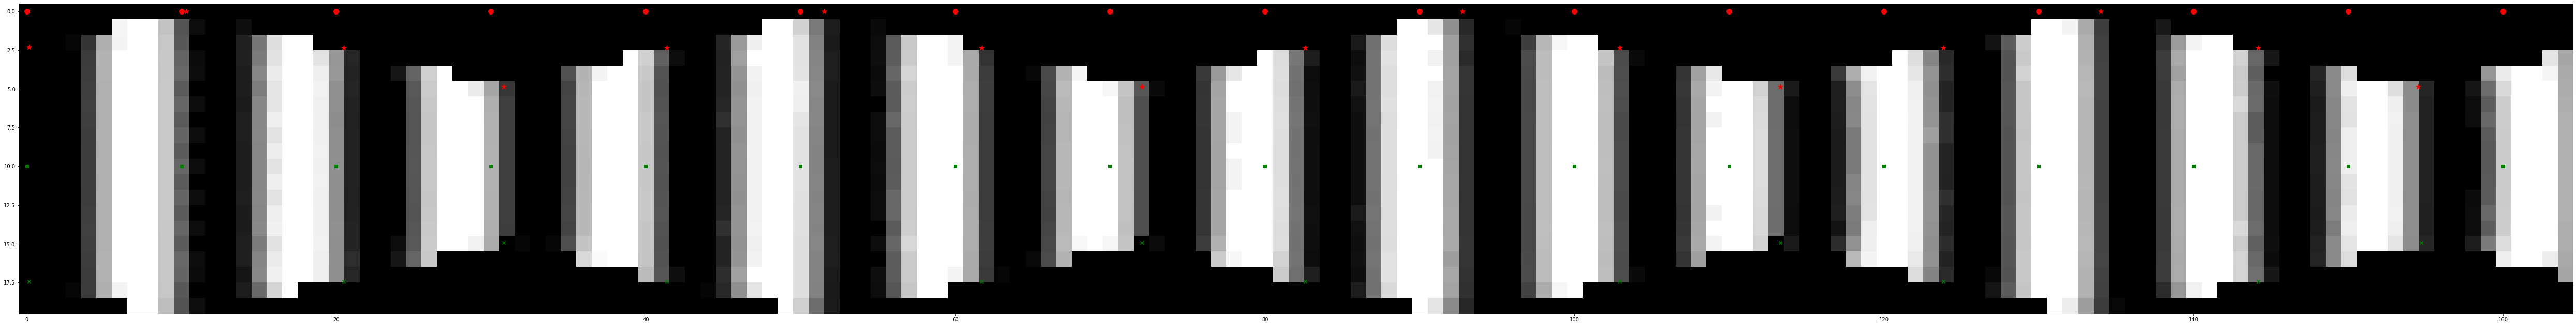

In [19]:
fig, ax = plt.subplots(figsize=(img_width,img_height))
ax.scatter(c1[:,1],c1[:,0],c='r',marker='o',s=100, label='c1')
ax.scatter(c2[:,1],c2[:,0],c='g',marker='s',label='c2')

ax.scatter(c1_sin_new[:,1],c1_sin_new[:,0],c='r',marker='*',s=100, label='c1 reproject')
ax.scatter(c2_sin_new[:,1],c2_sin_new[:,0],c='g',marker='x',label='c2 reproject')
ax.imshow(img_reproj_sin, interpolation='nearest')

# Natural bend process

At each joint, bend theta degrees (<90)</br>
Each col gets stretched by length of short side of right triangle formed by bend with inner cols getting compresed by max s/2 and outer expanded by s/2 with even scaling between.

In [398]:
# 
def bend_coords(row, height, bends, theta, ratio, bend_exp, ends_only=False):
   
    cur_angle = 0
    cur_theta = theta
    cur_row_start = row
    if ends_only:
        n_coords = bends.shape[0]
    else:
        n_coords = bends[-1]
    new_coords = np.zeros((n_coords, 2))
    if ends_only:
        orig_coords = bends
    else:
        orig_coords = np.concatenate([np.full((n_coords,1),row),np.arange(n_coords).reshape(-1,1)],axis=1)
    bend_diff = np.diff(bends) 
    cur_stretch = height/np.tan(np.deg2rad((90-cur_theta*0.5))) * (ratio-0.5)

    cur_col_start = -(cur_stretch)/2

    #new_lengths= bend_diff + scaling
    cur_sample = 0
    for offset in range(len(bend_diff)):
        n_samples = bend_diff[offset]
        cur_stretch = height/np.tan(np.deg2rad((90-cur_theta*0.5))) * (ratio-0.5)*2
        prev_theta = theta*(bend_exp**(offset-1))
        prev_stretch = height/np.tan(np.deg2rad((90-prev_theta*0.5))) * (ratio-0.5)*2

        #next_stretch =height/np.tan(np.deg2rad((90-cur_theta*0.5))) * (ratio-0.5)*2
        new_length = n_samples +  cur_stretch+(cur_stretch-prev_stretch)/2

        cur_ang_rad = np.deg2rad(cur_angle)
        rot_trans = np.asarray([[np.cos(cur_ang_rad),-np.sin(cur_ang_rad),cur_row_start],
                                [np.sin(cur_ang_rad),np.cos(cur_ang_rad),cur_col_start],
                                [0,0,1]])
        length_vec = np.asarray([[0],[new_length],[1]])
        new_end = rot_trans.dot(length_vec)[:2].flatten()
        if ends_only:
            new_coords[offset,:] = [cur_row_start, cur_col_start]
        else:
            if np.isclose(cur_row_start,new_end[0]):
                new_row_samp = np.ones((n_samples,)) * cur_row_start
            else:
                new_row_samp = np.arange(cur_row_start, new_end[0], (new_end[0]-cur_row_start)/n_samples)

            if np.isclose(cur_col_start,new_end[1]):
                new_col_samp = np.ones((n_samples,)) * cur_col_start
            else:
                new_col_samp = np.arange(cur_col_start, new_end[1], (new_end[1]-cur_col_start)/n_samples)
            new_end_sample = cur_sample+n_samples
        
            #print(cur_sample, new_end_sample, new_row_samp)
            new_coords[cur_sample:new_end_sample,0] = new_row_samp
            new_coords[cur_sample:new_end_sample,1] = new_col_samp
            cur_sample = new_end_sample
        
        cur_row_start = new_end[0]
        cur_col_start = new_end[1]
        cur_theta = theta*(bend_exp**(offset+1))
        cur_angle += cur_theta
    if ends_only:
        if ends_only:
            new_coords[-1,:] = new_end
       
    return new_coords, orig_coords

all_new_coords = []
orig_coords = []
for row in range(img_height):
    new, orig =bend_coords(row, img_height, c1[:,1], 12, row/(img_height-1),1)
    all_new_coords.append(new)
    orig_coords.append(orig)

c1_new_bend,_ = bend_coords(0, img_height, c1[:,1], 12, 0,1, ends_only=True)
c2_new_bend,_ = bend_coords(img_height-1, img_height, c1[:,1], 12, 1,1, ends_only=True)
all_new_coords = np.concatenate(all_new_coords, axis=0)
all_min = c2_new_bend.min(axis=0)
all_new_coords = all_new_coords - all_min
c1_new_bend = c1_new_bend - all_min
c2_new_bend = c2_new_bend - all_min
orig_coords = np.concatenate(orig_coords, axis=0)


(-5, 110)

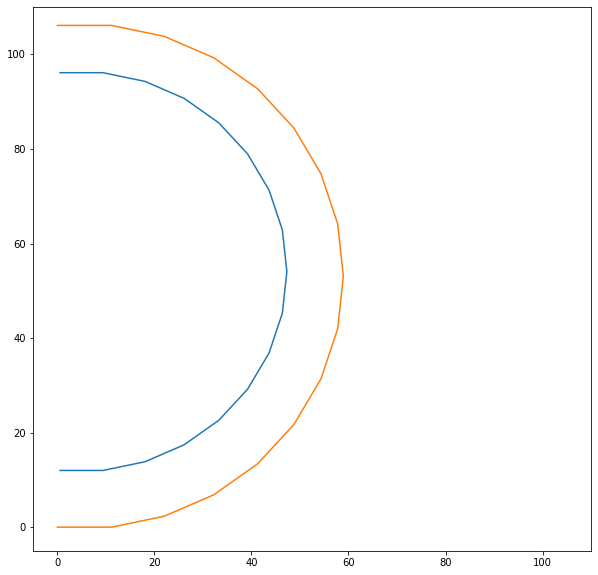

In [399]:
fig,ax = plt.subplots(figsize=(10,10))
ax.plot(c1_new_bend[:,1],c1_new_bend[:,0])
ax.plot(c2_new_bend[:,1],c2_new_bend[:,0])
ax.set_xlim(-5,110)
ax.set_ylim(-5,110)

In [400]:
#inside_poly = image_warping.inside_polygon(np.concatenate([c1,np.flipud(c2)],axis=0))

inside_spiral = image_warping.inside_polygon(np.concatenate([c1_new_bend,np.flipud(c2_new_bend)],axis=0))
coords_search = cKDTree(all_new_coords)
nearest_distances, nearest_indexes = coords_search.query(inside_spiral, 1, n_jobs=-1)
spiralmax = c2_new_bend.max(axis=0)

spiral_proj = np.zeros((int(spiralmax[0])+2, int(spiralmax[1])+2, 3))
for ind in range(len(inside_spiral)):
    nn = nearest_indexes[ind]
    spiralloc = np.round(inside_spiral[ind]).astype(int)
    flatloc = orig_coords[nn]
    spiral_proj[spiralloc[0],spiralloc[1],:] = img[flatloc[0],flatloc[1],:] 
    

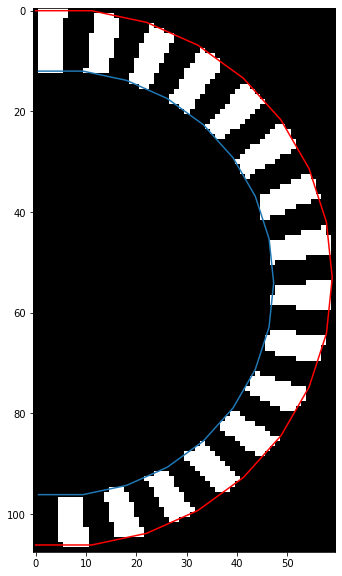

In [401]:
fig, ax = plt.subplots(figsize=(10,10))


ax.plot(c1_new_bend[:,1],c1_new_bend[:,0])#,c='r',marker='o',s=100, label='c1')
ax.plot(c2_new_bend[:,1],c2_new_bend[:,0],'r')#,c='g',marker='s',label='c2')
ax.imshow(spiral_proj, interpolation='nearest')


In [402]:
img_reproj_spir, c2_spir_new,c1_spir_new, proj_err = image_warping.reproject_snakelike(c2_new_bend, c1_new_bend, spiral_proj, projection_radius_out=True, verbose=True, n_nearest=1)

Calculating ratio line coordinates


[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00

Calculating ratio line coordinates



Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00

Calculating ratio line coordinates



Total time elapsed: 00:00:00
[100 %] Time elapsed: 00:00:00 | ETA: 00:00:00
Total time elapsed: 00:00:00


Calculating ratio line coordinates


[100 %] Time elapsed: 00:00:12 | ETA: 00:00:00
Total time elapsed: 00:00:12


Determining inside coordinates in projected space.
Finding nearest neighbors.
Building image.


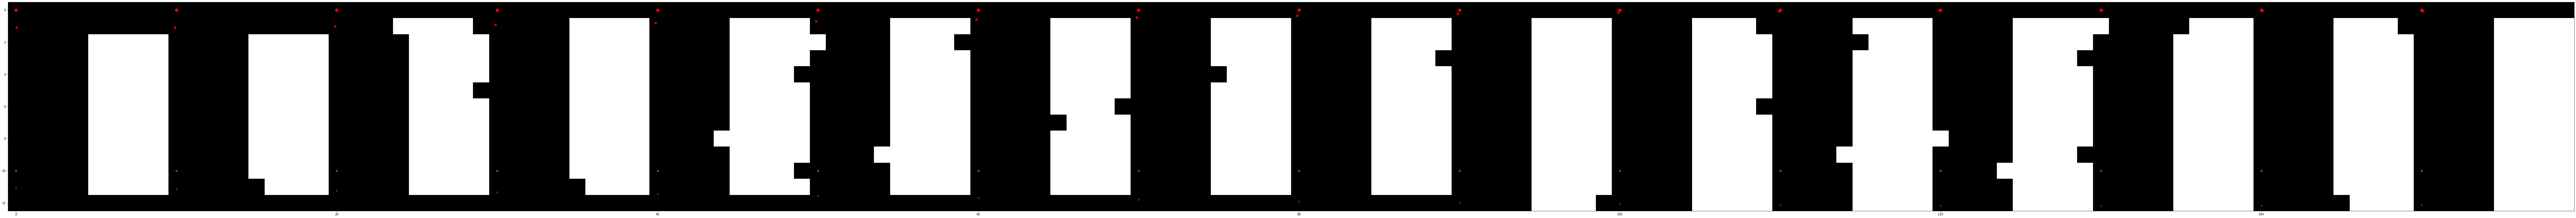

In [403]:
new_height = img_reproj_spir.shape[0]
new_width = img_reproj_spir.shape[1]

fig, ax = plt.subplots(figsize=(new_width,new_height))
ax.scatter(c1[:,1],c1[:,0],c='r',marker='o',s=100, label='c1')
ax.scatter(c2[:,1],c2[:,0],c='g',marker='s',label='c2')

ax.scatter(c1_spir_new[:,1],c1_spir_new[:,0],c='r',marker='*',s=100, label='c1 reproject')
ax.scatter(c2_spir_new[:,1],c2_spir_new[:,0],c='g',marker='x',label='c2 reproject')
ax.imshow(img_reproj_spir, interpolation='nearest')


In [404]:
img_reproj_spir.shape

(13, 160, 3)

In [405]:
eq = img_reproj_spir[1:-1,:160,0] == img[:,:160,0]

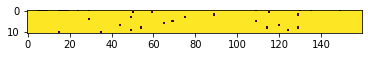

In [406]:
plt.imshow(eq)

In [407]:
eq.mean()

0.9795454545454545

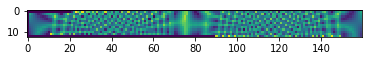

In [410]:
plt.imshow(proj_err)

In [412]:
proj_err.max()

0.8372682803724617

In [413]:
all_new_coords[0:10]+all_min

array([[0.        , 0.28903665],
       [0.        , 1.17342199],
       [0.        , 2.05780733],
       [0.        , 2.94219267],
       [0.        , 3.82657801],
       [0.        , 4.71096335],
       [0.        , 5.59534869],
       [0.        , 6.47973404],
       [0.        , 7.36411938],
       [0.        , 8.24850472]])